In [1]:
import re
from copy import deepcopy

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [2]:
np.set_printoptions(precision=4)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
DATADIR = 'data/'

Use slightly different utility functions from feed-forward tagger

In [5]:
def read_corpus(file):
    """
    returns:
        lines: [['hello', 'world'], ...]
        labels: [[!, N], ...], a list of variable len tensors
        vocab, all_labels
    """
    with open(file, 'rt') as f:
        text = f.read()
    lines = text.split('\n\n')
    ret_lines = []
    ret_labels = []
    vocab = set()
    all_labels = set()
    for line in lines:
        if not line: 
            continue
        curr_line = []
        curr_line_labels = []
        for token_label_str in line.split('\n'):
            if not token_label_str: 
                continue
            token, label = token_label_str.split('\t')
            vocab.add(token)
            all_labels.add(label)
            curr_line_labels.append(label)
            curr_line.append(token)
            
        ret_labels.append(curr_line_labels)
        ret_lines.append(curr_line)
        
    return ret_lines, ret_labels, vocab, all_labels

In [6]:
def encode_lines(lines, word2idx_map):
    """
    returns:
        a list of len(line) x 1 tensors
        a list of unpadded lengths
    a list of variable length tensor for pad_sequence
    """
    ret = []
    ret_lengths = []
    for line in lines:
        encoded_line = []
        for word in line:
            num = word2idx_map.get(word, word2idx_map['UUUNKKK'])
            encoded_line.append(num)
        ret.append(torch.tensor(encoded_line))
        ret_lengths.append(len(line))
    return ret, ret_lengths

In [7]:
def encode_labels(line_labels, encoder):
    """
    returns a list of len(line) x 1 tensors
    a list of variable length tensor for pad_sequence
    """
    ret = []
    for line_label in line_labels:
        encoded = encoder.transform(line_label)
        ret.append(torch.tensor(encoded, dtype=torch.long))
    return ret

In [54]:
class Seq2SeqTagger(nn.Module):
    def __init__(self, pretrained_embedding, output_dim, rnn_layer_func, 
                 pad_length, bidirectional=False):
        """
        rnn_layer_func could be nn.RNN, nn.GRU, or nn.LSTM
        output_dim is the number of tag classes
        use 128 for hidden
        """
        super(Seq2SeqTagger, self).__init__()
    
        input_dim = pretrained_embedding.shape[1]
        self.hidden_dim = 128
        self.output_dim = output_dim
        self.bidirectional = bidirectional
        self.pad_length = pad_length
        
        self.emb = nn.Embedding.from_pretrained(pretrained_embedding)
        
        self.rnn = rnn_layer_func(input_dim, 
                                  hidden_size=self.hidden_dim, 
                                  batch_first=True,
                                  bidirectional=self.bidirectional)
        if self.bidirectional:
            self.fc = nn.Linear(2 * self.hidden_dim, self.output_dim)
        else:
            self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, inputs, unpadded_lengths):
        x = self.emb(inputs)
        x_packed = pack_padded_sequence(x, unpadded_lengths, batch_first=True, 
                                        enforce_sorted=False)
        outputs = torch.zeros(x.shape[0], x.shape[1], self.output_dim)
        hidden = None
        for i in range(x.shape[1]):
            out, hidden = self.rnn(x_packed.data[:, i], hidden)
            outputs[:, i] = out

        outputs, _ = pad_packed_sequence(out, batch_first=True,
                                    total_length=self.pad_length)
        outputs = self.fc(outputs)
        log_probs = F.log_softmax(outputs, dim=2)
        return log_probs

In [52]:
def train_util(model, X_train, X_train_lengths, Y_train, X_dev, X_dev_lengths, Y_dev, 
               n_epochs, lr, batch_size):
    """
    returns: best_model, losses, train_accu_list, dev_accu_list
    """
    # for accuracy_score
    Y_train_1d = Y_train.flatten()
    Y_dev_1d = Y_dev.flatten()
    
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    best_model = None
    best_dev_accu = 0
    losses = []
    train_accu_list, dev_accu_list = [], []
    
    progress_bar = tqdm.trange(1, n_epochs + 1)
    for epoch in progress_bar:
        epoch_loss = 0
        model.train()
        
        for i in range(0, X_train.shape[0], batch_size):
            optimizer.zero_grad()
            log_probs = model(X_train[i : i + batch_size],
                             X_train_lengths[i : i + batch_size])
            # reshape log_probs and labels
            log_probs_2d = log_probs.view(
                log_probs.shape[0] * log_probs.shape[1], -1)
            targets = Y_train[i : i + batch_size]
            targets_1d = targets.view(targets.shape[0] * targets.shape[1]) 
           
            loss = loss_func(log_probs_2d, targets_1d)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # eval
        model.eval()       
        with torch.no_grad():
            train_preds = torch.argmax(model(X_train, X_train_lengths), 
                                       dim=2).flatten()
            train_accu = accuracy_score(Y_train_1d, train_preds)
            # evaluate on dev
            dev_preds = torch.argmax(model(X_dev, X_dev_lengths), 
                                     dim=2).flatten()
            dev_accu = accuracy_score(Y_dev_1d, dev_preds)
        
        # early stopping, save the model if it has improved on dev
        if dev_accu > best_dev_accu:
            best_dev_accu = dev_accu
            best_model = deepcopy(model)
        
        progress_bar.set_description(
            'Epoch {}: train_loss {:.4f}, train_accu: {:.4f}, dev_accu: {:.4f}'\
              .format(epoch, epoch_loss, train_accu, dev_accu))
        losses.append(epoch_loss)
        train_accu_list.append(train_accu)
        dev_accu_list.append(dev_accu)
        
    loss_accu_df = pd.DataFrame({
        'epoch': range(1, n_epochs + 1), 
        'loss': losses,
        'train_accu': train_accu_list,
        'dev_accu': dev_accu_list})
        
    return best_model, loss_accu_df

In [10]:
def plot_loss_accu(loss_accu_df_list, rnn_type_list):
    """
    input: two lists of the same length, loss_accu_df, window
    """
    dfs = []
    for df, rnn in zip(loss_accu_df_list, rnn_type_list):
        df1 = df.melt(
            'epoch', value_vars=['loss']).assign(rnn_type=rnn, plot='loss')
        df2 = df.melt(
            'epoch', value_vars=['train_accu', 'dev_accu']).assign(rnn_type=rnn, plot='accu')
        dfs.extend([df1, df2])
    plot_df = pd.concat(dfs)

    g = sns.FacetGrid(data=plot_df, row='plot', col='rnn_type', 
                      hue='variable', sharey=False)
    g.map_dataframe(sns.lineplot, x='epoch', y='value')
    g.add_legend()

def plot_confusion_matrix(matrix, labels, title):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, 
                     annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Predictions')
    ax.set_ylabel('True labels')
    ax.set_title(title)

# Load pretrained embedding 

In [11]:
twitter_vocab = []
emb_list = []
with open(DATADIR + 'twitter-embeddings.txt', 'rt') as f:
    for line in f:
        tokens = line.split(' ')
        word, emb = tokens[0], tokens[1:]
        emb = [float(elm) for elm in emb]
        twitter_vocab.append(word)
        emb_list.append(emb)

In [12]:
twitter_emb = torch.tensor(emb_list)
# add empty string as the first index for padding
# for <s>, use the emb for </s>
idx2word_pretrained = [''] + twitter_vocab + ['<s>']
# construct maps for pretrained word embs
word2idx_pretrained = {word: idx for idx, word in enumerate(idx2word_pretrained)}
temp = twitter_emb[word2idx_pretrained['</s>']].view((1, -1))
twitter_emb = torch.cat((twitter_emb, temp))

# Load data

In [13]:
train, train_labels, train_vocab, all_labels = read_corpus(DATADIR + 'twpos-train.tsv')
dev, dev_labels, dev_vocab, _ = read_corpus(DATADIR + 'twpos-dev.tsv')
devtest, devtest_labels, devtest_vocab, all_labels_devtest = read_corpus(DATADIR + 'twpos-devtest.tsv')

In [14]:
# need to zero-pad lines and labels
# add empty label before encoding all labels
all_labels.add('')
all_labels = np.array(list(all_labels))
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
label_encoder.classes_

array(['', '!', '#', '$', '&', ',', '@', 'A', 'D', 'E', 'G', 'L', 'M',
       'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', '^', '~'],
      dtype='<U1')

In [15]:
all_labels_devtest = sorted(all_labels_devtest)
print(all_labels_devtest)

['!', '#', '$', '&', ',', '@', 'A', 'D', 'E', 'G', 'L', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', '^', '~']


# Encode and Zero-pad data

In [16]:
X_train, X_train_lengths = encode_lines(train, word2idx_pretrained)
X_dev, X_dev_lengths = encode_lines(dev, word2idx_pretrained)
X_devtest, X_devtest_lengths = encode_lines(devtest, word2idx_pretrained)
Y_train = encode_labels(train_labels, label_encoder)
Y_dev = encode_labels(dev_labels, label_encoder)
Y_devtest = encode_labels(devtest_labels, label_encoder)

In [17]:
# compute global pad_length
pad_length = max(X_train_lengths + X_dev_lengths + X_devtest_lengths)
pad_length

38

In [18]:
# pad train, dev, devtest to same input_dim
# (num_samples, input_dim)
X_padded = pad_sequence([*X_train, *X_dev, *X_devtest], batch_first=True)
Y_padded = pad_sequence([*Y_train, *Y_dev, *Y_devtest], batch_first=True)

In [19]:
X_padded.shape, len(X_train), len(X_dev), len(X_devtest)

(torch.Size([1827, 38]), 1173, 327, 327)

In [20]:
X_train_padded = X_padded[:len(X_train)]
X_dev_padded = X_padded[len(X_train) : len(X_train) + len(X_dev)]
X_devtest_padded = X_padded[-len(X_devtest):]

In [21]:
X_train_padded.shape, X_dev_padded.shape, X_devtest_padded.shape

(torch.Size([1173, 38]), torch.Size([327, 38]), torch.Size([327, 38]))

In [22]:
Y_train_padded = Y_padded[:len(Y_train)]
Y_dev_padded = Y_padded[len(Y_train) : len(Y_train) + len(Y_dev)]
Y_devtest_padded = Y_padded[-len(Y_devtest):]

In [23]:
# flatten for accuracy_score
Y_devtest_padded_1d = Y_devtest_padded.flatten() 

# Train

In [55]:
model_rnn = Seq2SeqTagger(
    pretrained_embedding=twitter_emb, output_dim=all_labels.size, 
    rnn_layer_func=nn.RNN, pad_length=pad_length)

best_model_rnn, rnn_df = train_util(
    model_rnn, X_train_padded, X_train_lengths, Y_train_padded, 
    X_dev_padded, X_dev_lengths, Y_dev_padded, 
    n_epochs=80, lr=1, batch_size=100)

  0%|          | 0/80 [00:00<?, ?it/s]


RuntimeError: input must have 3 dimensions, got 1

In [31]:
devtest_preds = torch.argmax(best_model_rnn(X_devtest_padded, X_devtest_lengths), 
                             dim=2).flatten()
devtest_accu = accuracy_score(Y_devtest_padded_1d, devtest_preds)
conf_matrix_rnn = confusion_matrix(Y_devtest_padded_1d, devtest_preds)
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8309


In [36]:
model_gru = Seq2SeqTagger(
    pretrained_embedding=twitter_emb, output_dim=all_labels.size, 
    rnn_layer_func=nn.GRU, pad_length=pad_length)

best_model_gru, gru_df = train_util(
    model_gru, X_train_padded, X_train_lengths, Y_train_padded,
    X_dev_padded, X_dev_lengths, Y_dev_padded, n_epochs=80, lr=1, batch_size=100)

Epoch 80: train_loss 1.9100, train_accu: 0.8088, dev_accu: 0.8041: 100%|██████████| 80/80 [00:46<00:00,  1.73it/s]


In [37]:
devtest_preds = torch.argmax(best_model_gru(X_devtest_padded, X_devtest_lengths), 
                             dim=2).flatten()
devtest_accu = accuracy_score(Y_devtest_padded_1d, devtest_preds)
conf_matrix_gru = confusion_matrix(Y_devtest_padded_1d, devtest_preds)
print('devtest_accu: {:.4f}'.format(devtest_accu))

devtest_accu: 0.8148


In [39]:
devtest_preds==0

tensor([False, False,  True,  ...,  True,  True,  True])

In [41]:
sum(devtest_preds==0), sum(Y_devtest_padded_1d==0)

(tensor(7788), tensor(7787))

In [ ]:
model_bigru = Seq2SeqTagger(
    pretrained_embedding=twitter_emb, 
    output_dim=all_labels.size, rnn_layer_func=nn.GRU,
    bidirectional=True
)
best_model_bigru, bigru_df = train_util(model_bigru, X_train_padded, Y_train_padded,
          X_dev_padded, Y_dev_padded, n_epochs=50, lr=0.5, batch_size=100)

In [ ]:
devtest_preds = torch.argmax(best_model_bigru(X_devtest_padded), dim=2).flatten()
devtest_accu = accuracy_score(Y_devtest_padded_1d, devtest_preds)
conf_matrix_bigru = confusion_matrix(Y_devtest_padded_1d, devtest_preds)
print('devtest_accu: {:.4f}'.format(devtest_accu))

# Plot

In [42]:
# truncate the empty string pad, i.e. class 0 from the confusion matrix
conf_matrix_rnn = conf_matrix_rnn[1:, 1:]
conf_matrix_gru = conf_matrix_gru[1:, 1:]
conf_matrix_bigru = conf_matrix_bigru[1:, 1:]

NameError: name 'conf_matrix_bigru' is not defined

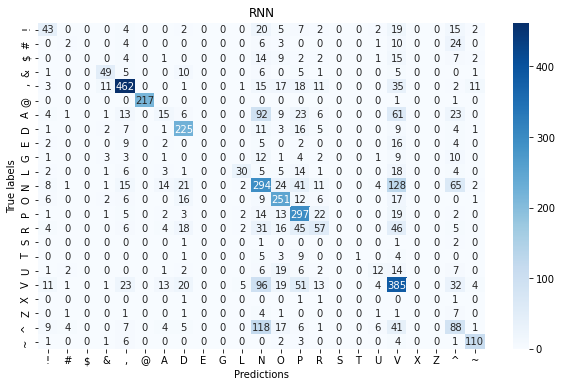

In [43]:
plot_confusion_matrix(conf_matrix_rnn, all_labels_devtest, 'RNN')

In [ ]:
plot_confusion_matrix(conf_matrix_gru, all_labels_devtest, 'GRU')

In [ ]:
plot_confusion_matrix(conf_matrix_bigru, all_labels_devtest, 
                      'Bidirectional GRU')

In [ ]:
plot_loss_accu([rnn_df, gru_df, bigru_df], 
               rnn_type_list=['RNN', 'GRU', 'Bi-GRU'])